###  Space, formally

*How do you express geographical relations between objects (e.g. areas, points) in a way that can be used in statistical analysis?*


**Spacial weights matrices**

Translating geography into numerical language.

NxN positive matrix that contains spatial relations between all the observations in the sample. Meaning with spatial relations that if you are neighbor of an observation you get a value > 0.

The diagonal that assigns the relation between an observation and itself it's set to 0 by convention. (An observation it's not the neighbor of itself)



**Types of weights**

What is a **neighbor?**

- next door -> Contiguity based Ws. Sharing boundaries. (Topological neighbor)
- close -> Distance based Ws. Weight is (inversely) proportional to distance between observations. Inverse distance (threshold), KNN (fixed number of neighbor), ...
- In the same 'place' as us -> Block based Ws. Weights are assigned based on discretionary rules loosely related to geography. (Definition that an agency has decided. ex: post-code, states... )

> How much of a neighbor?

- non-neighbors receive zero weights: Wij = 0
- neighbors, it depends:
	- binary wij = 1
	- continuous 0 < wij < continuous


> Choice of W

Should be based on and reflect the underlying channels of interactions that you want to capture.

Examples:
- Processes propagated by immediate contact (ex: disease contagion) -> Contiguity weights
- Accessibility -> Distance weights
- Effects of country differences in law -> Block weights


In [1]:
import seaborn as sns
import pandas as pd
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read the file in
db = gpd.read_file(
    "https://darribas.org/gds_course/content/data/liv_lsoas.gpkg"
)
# Index table on the LSOA ID
db = db.set_index("LSOA11CD", drop=False)
# Display summary
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  298 non-null    object  
 1   MSOA11CD  298 non-null    object  
 2   geometry  298 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 9.3+ KB


<Axes: >

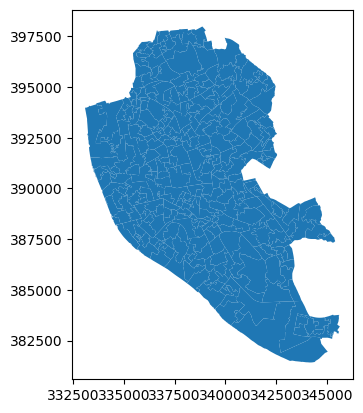

In [3]:
db.plot()

**Queen criteria**: two observations only need to share a vortex (single point)

In [5]:
w_queen = weights.Queen.from_dataframe(db, ids="LSOA11CD")
w_queen

In [6]:
w_queen['E01006690']

{'E01006759': 1.0,
 'E01006697': 1.0,
 'E01006691': 1.0,
 'E01006695': 1.0,
 'E01006692': 1.0,
 'E01006720': 1.0,
 'E01033763': 1.0}

In [7]:
w_queen.neighbors['E01006690']

['E01006759',
 'E01006697',
 'E01006691',
 'E01006695',
 'E01006692',
 'E01006720',
 'E01033763']

In [8]:
w_queen.weights['E01006690']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [9]:
# We have direct access to the number of neighbors each observation has via the attribute cardinalities.
w_queen.cardinalities['E01006524']

6

In [10]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head()

E01006512    6
E01006513    9
E01006514    5
E01006515    8
E01006518    5
dtype: int64

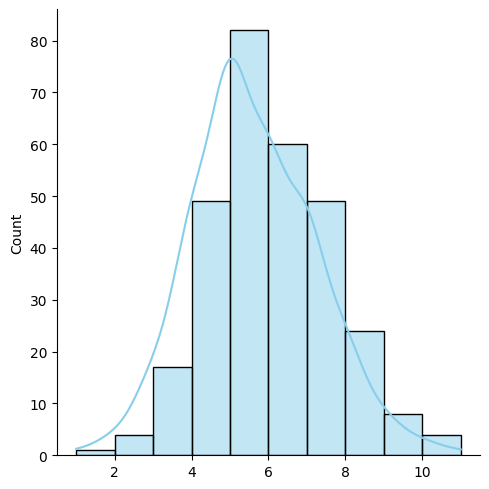

In [13]:
# size of neighborhoods in general
sns.displot(queen_card, bins=10, kde=True, color='skyblue');

In [14]:
print('Number of observations', w_queen.n)
print('Average number of neighbors', w_queen.mean_neighbors)
print('Min number of neighbors', w_queen.min_neighbors)
print('Max number of neighbors', w_queen.max_neighbors)
print('Island (observations disconnected)', w_queen.islands)
print('Order of IDs', w_queen.id_order[:5])

Number of observations 298
Average number of neighbors 5.617449664429531
Min number of neighbors 1
Max number of neighbors 11
Island (observations disconnected) []
Order of IDs ['E01006512', 'E01006513', 'E01006514', 'E01006515', 'E01006518']


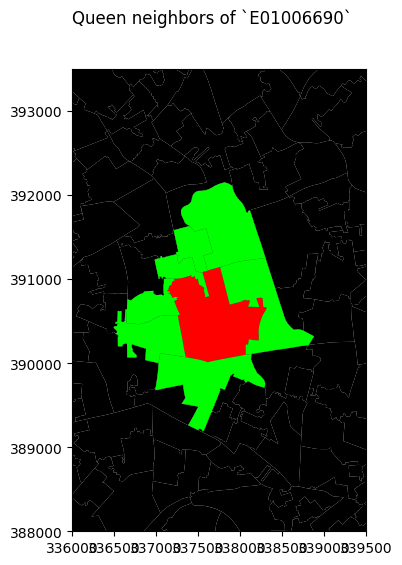

In [15]:
f, ax = plt.subplots(1, figsize=(6, 6))

# Plot base layer of polygons
db.plot(ax=ax, facecolor='k', linewidth=0.1)

# Select focal polygon
focus = db.loc[['E01006690'], ['geometry']]

# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)

# Plot neighbors
neis = db.loc[list(w_queen['E01006690'].keys()), :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)

f.suptitle("Queen neighbors of `E01006690`")

ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

**Rook criteria**: two observations need to share a line segment

In [16]:
w_rook = weights.Rook.from_dataframe(db)
w_rook

/tmp/ipykernel_31045/3845060362.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook = weights.Rook.from_dataframe(db)


## Distance

Distance based matrices assign the weight to each pair of observations as a function of how far from each other they are. 
We are going to explore three types of how these distance translate into actual weights: K-nearest neighbors, Distance band and Block weights

### KNN

In [17]:
knn5 = weights.KNN.from_dataframe(db, k=5)
knn5

In [19]:
cents = db.centroid

# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values

# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

### Distance band
Draw a circle of certain radious and consider neighbor every observation that falls within the circle

In [35]:
# binary = False we could think of assigning the inverse of the distance between observations i and j as wij

w_dist1kmB = weights.DistanceBand.from_dataframe(db, 1000, binary=False)

/home/pdb/miniconda3/lib/python3.12/site-packages/scipy/sparse/_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


### Block weights
Block weights connect every observation in a dataset that belongs to the same category in a list provided ex-ante

In [22]:
db.head()

,LSOA11CD,MSOA11CD,geometry
LSOA11CD,,,
E01006512,E01006512,E02001377,"POLYGON ((336103.358 389628.580, 336103.416 38..."
E01006513,E01006513,E02006932,"POLYGON ((335173.781 389691.538, 335169.798 38..."
E01006514,E01006514,E02001383,"POLYGON ((335495.676 389697.267, 335495.444 38..."
E01006515,E01006515,E02001383,"POLYGON ((334953.001 389029.000, 334951.000 38..."
E01006518,E01006518,E02001390,"POLYGON ((335354.015 388601.947, 335354.000 38..."


In [220]:
w_block = weights.block_weights(db['MSOA11CD'])

In [222]:
w_block[0]

{218: 1.0, 219: 1.0, 220: 1.0, 292: 1.0}

In [229]:
w_block.remap_ids(db.index)

In [231]:
w_block['E01006512']

{'E01006747': 1.0, 'E01006748': 1.0, 'E01006751': 1.0, 'E01033763': 1.0}

### Standardizing W matrices
Spatial weights matrix with raw values (e.g. ones and zeros for the binary case) is not always the best suiting one for analysis and some sort of transformation is required

In [23]:
w_queen['E01006690']

{'E01006759': 1.0,
 'E01006697': 1.0,
 'E01006691': 1.0,
 'E01006695': 1.0,
 'E01006692': 1.0,
 'E01006720': 1.0,
 'E01033763': 1.0}

In [24]:
w_queen.transform # 'O' stands for original, so no transformations have been applied yet

'O'

In [25]:
# To apply a row transformation, so every row of the matrix sums up to one,
w_queen.transform = 'R'
w_queen['E01006690']

{'E01006759': 0.14285714285714285,
 'E01006697': 0.14285714285714285,
 'E01006691': 0.14285714285714285,
 'E01006695': 0.14285714285714285,
 'E01006692': 0.14285714285714285,
 'E01006720': 0.14285714285714285,
 'E01033763': 0.14285714285714285}

In [26]:
pd.Series(w_queen['E01006690']).sum()

0.9999999999999998

In [27]:
# back to original
w_queen.transform = 'O'
w_queen['E01006690']

{'E01006759': 1.0,
 'E01006697': 1.0,
 'E01006691': 1.0,
 'E01006695': 1.0,
 'E01006692': 1.0,
 'E01006720': 1.0,
 'E01033763': 1.0}

PySAL supports the following transformations:

- O: original, returning the object to the initial state.
- B: binary, with every neighbor having assigned a weight of one.
- R: row, with all the neighbors of a given observation adding up to one.
- V: variance stabilizing, with the sum of all the weights being constrained to the number of observations.

### Reading and writing spatial weights in PySAL

.gal files for contiguity weights
.gwt files for distance-based weights.

In [30]:
fo = psopen('data/imd_queen.gal', 'w')

# Write the matrix into the file
fo.write(w_queen)

# Close the file
fo.close()

In [33]:
# Read it back
w_queen2 = psopen('data/imd_queen.gal', 'r').read()
w_queen2

In [36]:
fo = psopen('data/imd_dist1km.gwt', 'w')

# Write matrix into the file
fo.write(w_dist1kmB)

fo.close()

In [39]:
w_dist1km2 = psopen('data/imd_dist1km.gwt', 'r').read()

/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/io/iohandlers/gwt.py:84: RuntimeWarning: DBF relating to GWT was not found, proceeding with unordered string IDs.
  w = self._read()
/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/io/iohandlers/gwt.py:223: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, id_order)


In [40]:
w_dist1km2.remap_ids(db.index)

### Spatial Lag

Ysl (N x 1) = W (N x N) * Y (N x 1)


The Y could be population, income, presence of animal species... Anything that has location attached to it.

Intuition: Measure that captures the behavior of a variable in the neighborhood of a given observation

If W is standardized, the spatial lag is the average value of the variable in the neighborhood.

In [371]:
# we will use the area of each polygon as the variable of interest

db["area"] = np.log(db.area)

In [373]:
# Row-standardize the queen matrix
w_queen.transform = 'R'

# Compute spatial lag of `area`
w_queen_score = weights.lag_spatial(w_queen, db["area"])

# Print the first five elements
w_queen_score[:5]

array([12.40660189, 12.54225296, 12.28284814, 12.61675295, 12.55042815])

In [376]:
db['w_area'] = w_queen_score

### Moran Plot

Graphical way to start exploring the concept of spatial autocorrelation.

It is a standard scatter plot in which a given variable (area, for example) is plotted against its own spatial lag

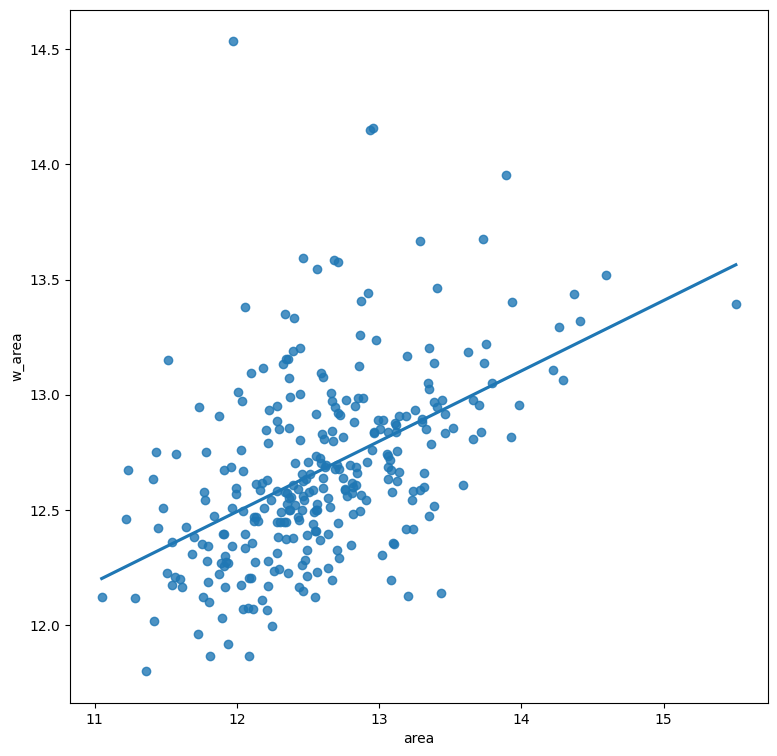

In [387]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot values
sns.regplot(x="area", y="w_area", data=db, ci=None)

plt.show()

Creating a standardized Moran Plot implies that average values are centered in the plot (as they are zero when standardized) and dispersion is expressed in standard deviations, with the rule of thumb of values greater or smaller than two standard deviations being outliers. A standardized Moran Plot also partitions the space into four quadrants that represent different situations:

High-High (HH): values above average surrounded by values above average.

Low-Low (LL): values below average surrounded by values below average.

High-Low (HL): values above average surrounded by values below average.

Low-High (LH): values below average surrounded by values above average.

These will be further explored once spatial autocorrelation has been properly introduced in subsequent blocks.

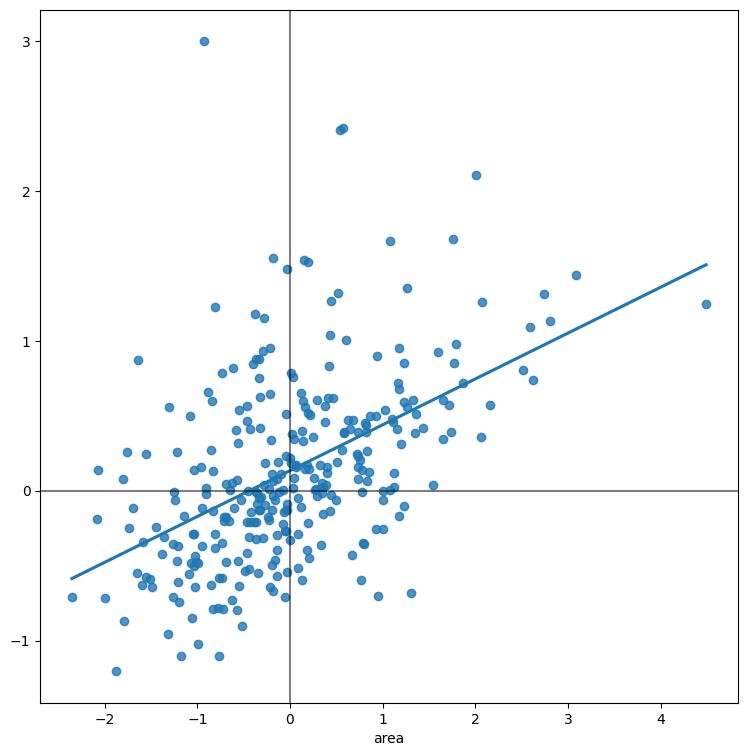

In [ ]:
# Standardize the area
std_db = (db['area'] - db['area'].mean()) / db['area'].std()
# Compute the spatial lag of the standardized version and save is as a
# Series indexed as the original variable
std_w_db = pd.Series(
    weights.lag_spatial(w_queen, std_db), index=std_db.index
)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_db, y=std_w_db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

### Do-it-yourself

In [51]:
import geopandas
import contextily
from pysal.lib import examples

## Task I: NYC tracts

In [52]:
examples.explain("NYC Socio-Demographics")

In [53]:
# Load example (this automatically downloads if not available)
nyc_data = examples.load_example("NYC Socio-Demographics")

# Print the paths to all the files in the dataset
nyc_data.get_file_list()

['/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.dbf',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shx',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shp',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.prj',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shp',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shx',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.prj',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.dbf']

<Axes: >

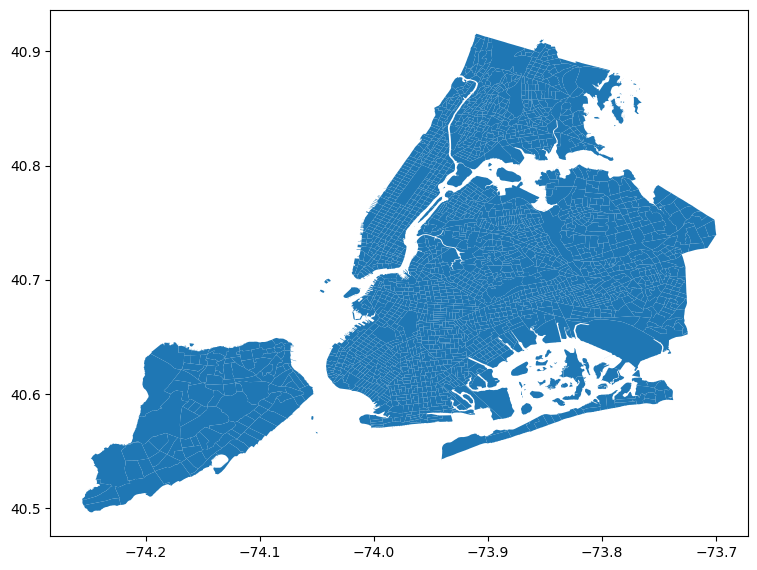

In [54]:
nyc = geopandas.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))
nyc.plot(figsize=(9, 9))

In [55]:
w_queen = weights.Queen.from_dataframe(nyc, use_index=True)
w_queen

/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 0, 626, 2165.
  W.__init__(self, neighbors, ids=ids, **kw)


In [56]:
nyc = nyc.set_crs(epsg=25830)
nyc.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

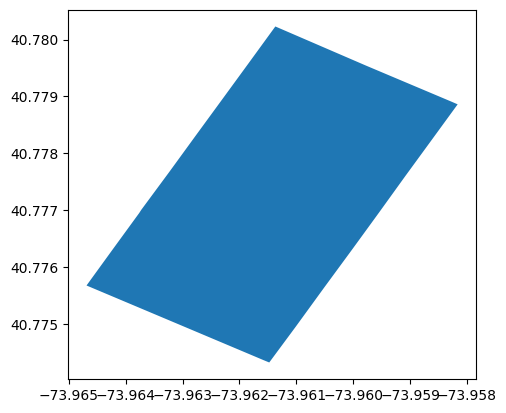

In [57]:
nyc[nyc['cartodb_id'] == 142].plot()

In [58]:
# Neighbours of central part: cartdb_id 142
w_queen[142]

{192: 1.0,
 130: 1.0,
 195: 1.0,
 199: 1.0,
 137: 1.0,
 204: 1.0,
 141: 1.0,
 145: 1.0,
 151: 1.0,
 152: 1.0,
 153: 1.0,
 156: 1.0,
 222: 1.0,
 161: 1.0,
 165: 1.0,
 166: 1.0,
 167: 1.0,
 171: 1.0,
 123: 1.0,
 174: 1.0,
 175: 1.0,
 110: 1.0,
 111: 1.0,
 114: 1.0,
 179: 1.0,
 180: 1.0,
 181: 1.0,
 183: 1.0,
 187: 1.0,
 191: 1.0}

In [59]:
neighbors = list(w_queen[142].keys())
len(neighbors)

30

Plot entral Park neighbors using queen weights matrix, neighbors are the ones that share edge with the query polygon

(40.75, 40.85)

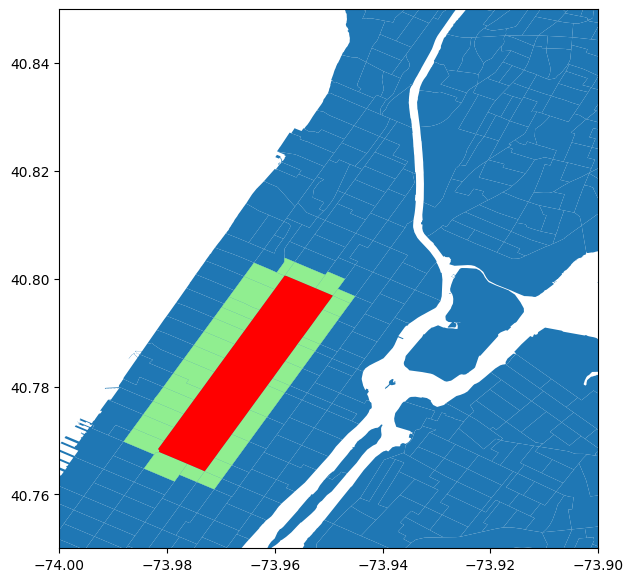

In [60]:
f, ax = plt.subplots(1, figsize=(8, 7))
nyc.plot(ax=ax, linewidth=0.2)
nyc.loc[neighbors, :].plot(ax=ax, facecolor='#90EE90')
nyc.loc[[142], :].plot(ax=ax, facecolor='r')

ax.set_xlim(-74.0, -73.9)
ax.set_ylim(40.75, 40.85)

Create a block spatial weights matrix where every tract is connected to other tracts in the same borough. For that, use the borocode column of the nyc table.

In [61]:
w_block = weights.block_weights(nyc['borocode'])

/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/util.py:296: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  w = W(neighbors, **kwargs)


In [62]:
len(w_block[142])

287

(40.6, 40.9)

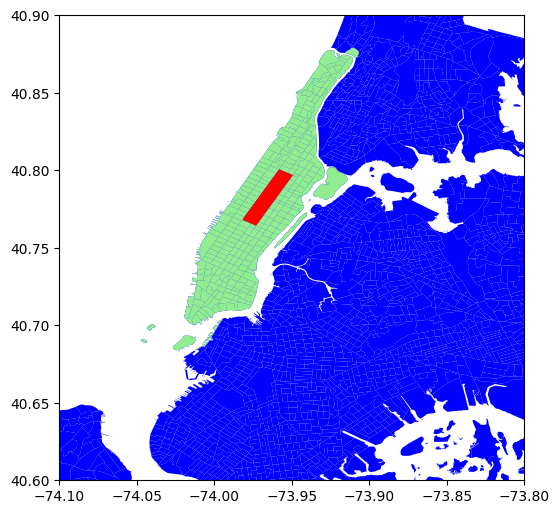

In [63]:
f, ax = plt.subplots(figsize=(6, 8))

nyc.plot(ax=ax, facecolor='b', linewidth=0.2)

nyc.loc[list(w_block[142].keys()), :].plot(ax=ax, facecolor='#90EE90')
nyc.loc[[142], :].plot(ax=ax, facecolor='r')

ax.set_xlim(-74.1, -73.8)
ax.set_ylim(40.6, 40.9)

## Task II: Japanese cities
Generate spatial weights matrices based on distance

In [67]:
jp_cities = geopandas.read_file('data/japan/407464-JPN.zip')
jp_cities.head()

,fuacode,fuaname,geometry
0,JPN47,Isesaki,"MULTIPOLYGON Z (((139.32669 36.63338 0.00000, ..."
1,JPN35,Kochi,"MULTIPOLYGON Z (((133.50243 33.46526 0.00000, ..."
2,JPN04,Fukuoka,"MULTIPOLYGON Z (((130.26444 33.59449 0.00000, ..."
3,JPN32,Fukui,"MULTIPOLYGON Z (((135.96490 35.99799 0.00000, ..."
4,JPN45,Kusatsu,"POLYGON Z ((135.98334 35.12212 0.00000, 136.00..."


<Axes: >

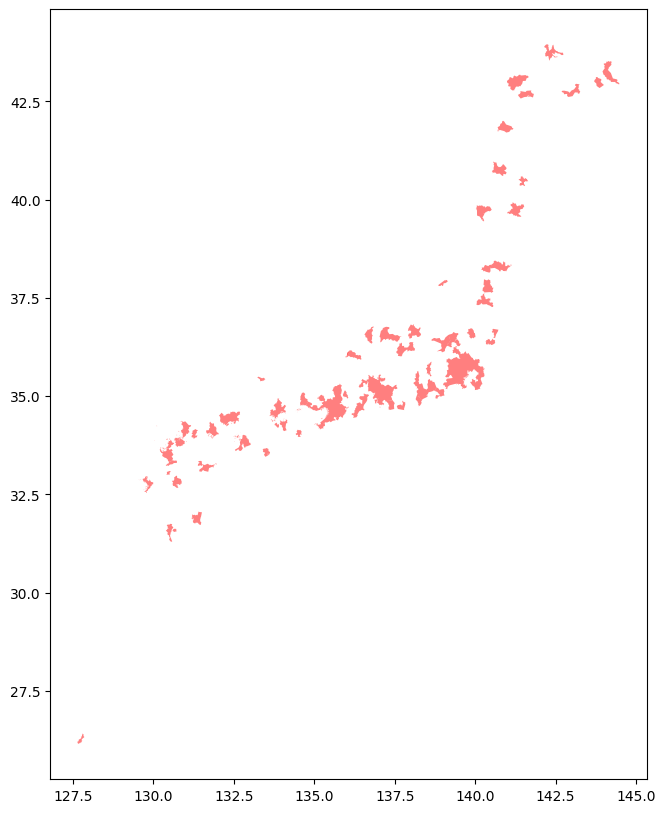

In [68]:
f, ax = plt.subplots(1, figsize=(10, 10))
jp_cities.plot(ax=ax, color='r', alpha=0.5)
#contextily.add_basemap(ax=ax, crs=jp_cities.crs)

In [69]:
jp_cities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [70]:
jp = jp_cities.to_crs(epsg=2459)

In [19]:
# Easier to calculate distance between centroids with meters rather than with degrees
jp.crs

<Projected CRS: EPSG:2459>
Name: JGD2000 / Japan Plane Rectangular CS XVII
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore Okinawa-ken east of 130°E.
- bounds: (131.12, 24.4, 131.38, 26.01)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone XVII
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [71]:
jp.geometry = jp.geometry.centroid

<Axes: >

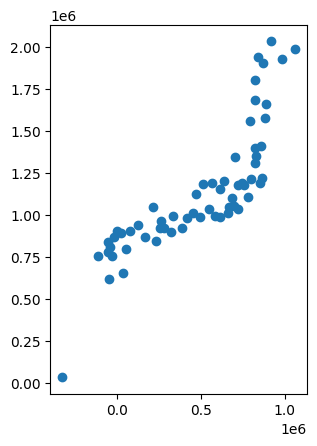

In [72]:
jp.plot()

In [73]:
# Generate a spatial weights matrix with five nearest neighbors

w_knn = weights.KNN.from_dataframe(jp, k=5)
w_knn

In [74]:
w_dist100km = weights.DistanceBand.from_dataframe(jp, 100000, binary=False) # dataset expressed in meters, not in kms
w_dist100km

/home/pdb/miniconda3/lib/python3.12/site-packages/scipy/sparse/_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 30, 42, 50, 60.
  w = W(neighbors, weights, ids, **kwargs)
/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 30, 42, 50, 60.
  W.__init__(


In [75]:
w_dist100km.mean_neighbors, w_knn.mean_neighbors

(3.3114754098360657, 5.0)

Generate a buffer of 100Km around the Tokyo centroid

In [76]:
jp[jp['fuaname'] == 'Tokyo']

,fuacode,fuaname,geometry
22,JPN01,Tokyo,POINT (782927.823 1105573.648)


In [77]:
# Tokyo neighbors of 100km
w_dist100km[22]

{0: 1.0556618593909542e-05,
 24: 1.0307225060681754e-05,
 34: 1.2690461462707179e-05,
 55: 1.0778724521881302e-05,
 57: 1.0242354028879608e-05}

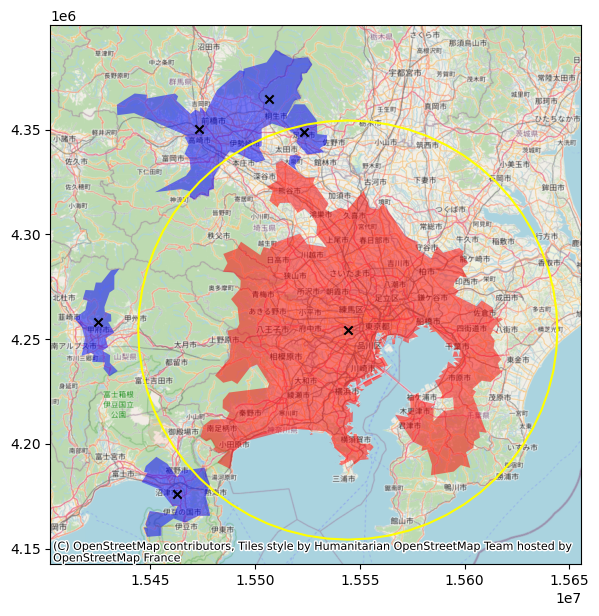

In [78]:
jp_cities = jp_cities.to_crs(epsg=3857)

f, ax = plt.subplots(1, figsize=(8, 7))

jp_cities[jp_cities['fuaname'] == 'Tokyo'].plot(ax=ax, color='r', alpha=0.5)
jp_cities.loc[list(w_dist100km[22].keys()), :].plot(ax=ax, color='b', alpha=0.5)

all_centroids = list(w_dist100km[22].keys())
all_centroids.append(22)
jp_cities.geometry.centroid[all_centroids].plot(ax=ax, marker='x', color='black')

x, y = jp_cities.loc[22].geometry.centroid.buffer(100000).exterior.xy
ax.plot(x, y, color='yellow')

contextily.add_basemap(ax=ax, crs=jp_cities.crs)

### Task III: Spatial lag

In [79]:
import geopandas

In [80]:
lsoas = geopandas.read_file("data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/shapefiles/E08000012.shp")
ahah_data = pd.read_csv("data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/tables/E08000012.csv")
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")

In [81]:
ahah.head()

,lsoa11cd,geometry,lsoa11nm,r_rank,h_rank,g_rank,e_rank,r_exp,h_exp,g_exp,...,d_pubs_dist,d_leis_dist,d_blue_dist,d_off_dist,d_tobac_dist,d_green_pas,d_green_act,d_no2_mean,d_pm10_mean,d_so2_mean
0,E01006512,"POLYGON ((336103.358 389628.580, 336103.416 38...",Liverpool 031A,31239,3055,31351,35965,30.888481,1.725173,31.123073,...,8,4,9,9,8,9,3,9,4,10
1,E01006513,"POLYGON ((335173.781 389691.538, 335169.798 38...",Liverpool 060A,41456,2213,37636,35878,90.685995,1.236631,50.819353,...,10,1,9,10,10,9,8,9,4,10
2,E01006514,"POLYGON ((335495.676 389697.267, 335495.444 38...",Liverpool 037A,37258,4510,39228,35143,49.017998,2.594648,60.485044,...,9,2,10,10,9,9,9,9,4,10
3,E01006515,"POLYGON ((334953.001 389029.000, 334951.000 38...",Liverpool 037B,34254,6931,29900,35065,38.227117,4.118458,28.254809,...,9,1,10,8,9,9,1,9,4,10
4,E01006518,"POLYGON ((335354.015 388601.947, 335354.000 38...",Liverpool 044A,25433,7533,37244,34392,21.166678,4.513573,48.953916,...,5,2,10,7,7,8,8,8,4,10


In [82]:
ahah['ahah']

0      26.870382
1      46.542967
2      38.256588
3      27.819724
4      28.315099
         ...    
293    23.614344
294    34.065745
295    23.056619
296    15.448627
297    30.345286
Name: ahah, Length: 298, dtype: float64

In [83]:
w_queen = weights.Queen.from_dataframe(ahah, ids='lsoa11cd')

In [85]:
w_queen.transform = 'R'

# Compute spatial lag of `ahah`
w_queen_score = weights.lag_spatial(w_queen, ahah["ahah"])

len(w_queen_score)

298

In [86]:
ahah['ahah_score'] = w_queen_score

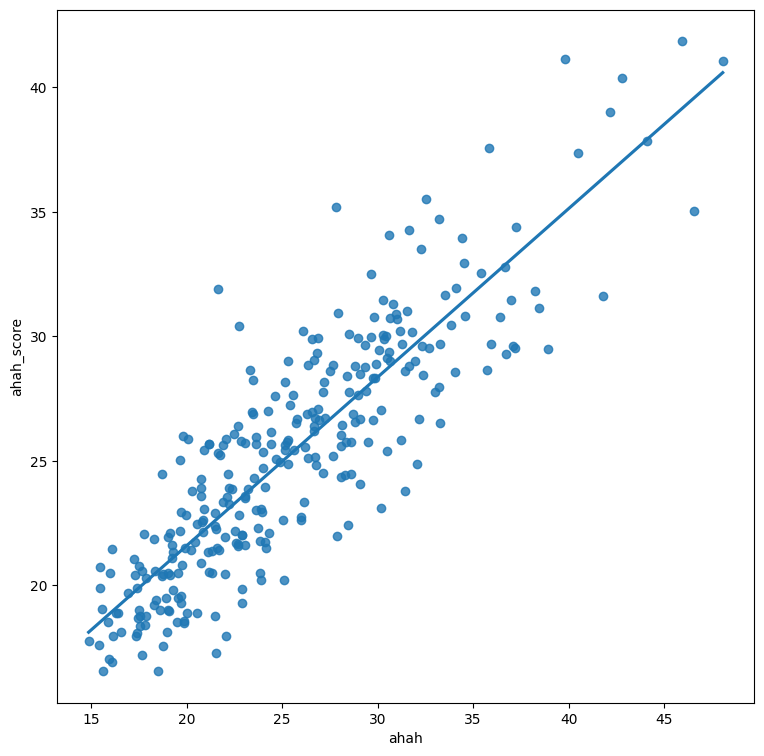

In [87]:
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot values
sns.regplot(x="ahah", y="ahah_score", data=ahah, ci=None)

plt.show()

In [88]:
# Standardize the area
std_db = (ahah['ahah'] - ahah['ahah'].mean()) / ahah['ahah'].std()

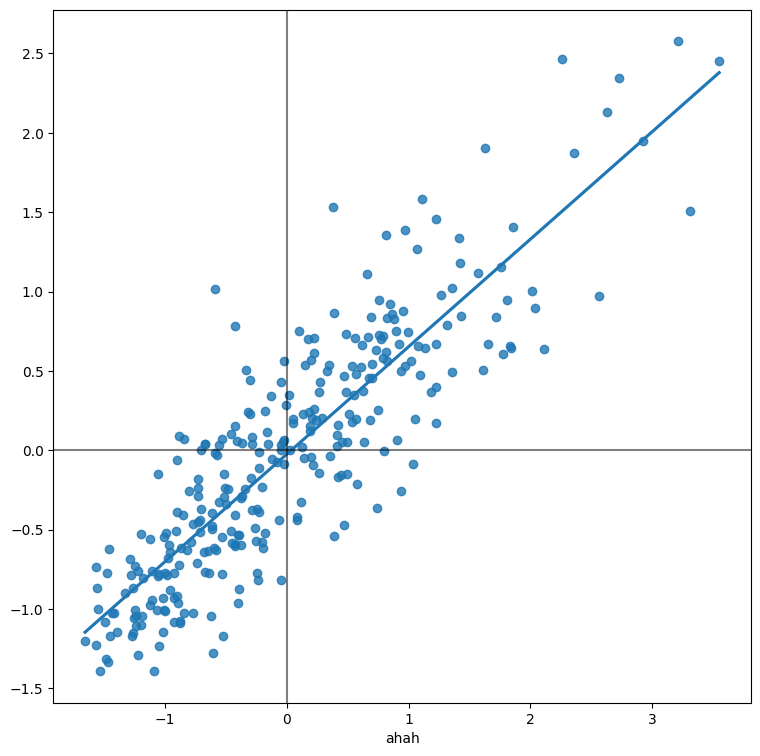

In [89]:
# Compute the spatial lag of the standardized version and save is as a Series indexed as the original variable
std_w_db = pd.Series(weights.lag_spatial(w_queen, std_db), index=std_db.index)

f, ax = plt.subplots(1, figsize=(9, 9))

sns.regplot(x=std_db, y=std_w_db, ci=None)

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

plt.show()

- right-top (high-high): indicates that neighbours have similar ahah score, clusters with high value
- left-bottom (low-low): indicates that neighbours have similar ahah score, clusters with low value

There are very few values in right-bottom and left-top: That means there are few outliers. Few points have high ahah score and are surrounded by points with low ahah score and viceversa.